In [27]:
import warnings
warnings.filterwarnings('ignore')
import requests
import re
import nltk
import random
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn import tree
from urllib import request
from random import randint
from nltk import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn import preprocessing
from nltk.stem import WordNetLemmatizer
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [28]:
books_url_list = ["https://www.gutenberg.org/files/84/84-0.txt",
                  "https://www.gutenberg.org/cache/epub/28434/pg28434.txt",
                  "https://www.gutenberg.org/cache/epub/3623/pg3623.txt",
                  "https://www.gutenberg.org/cache/epub/17866/pg17866.txt",
                  "https://www.gutenberg.org/files/3772/3772-0.txt"]

In [29]:
def model_svm(x_train, y_train, x_test):
    cs = SVC(kernel = 'linear', random_state = 0)
    cs.fit(x_train, y_train)
    y_pred = cs.predict(x_test)
    return y_pred, cs

# Preprocessing

In [30]:
#function read raw data
def read_books(url):
    files = []
    for i in url:
        file = requests.get(url = i)
        files.append(file.content.decode('utf-8'))
    return files

#read raw data
raw_dataset = read_books(books_url_list)
len(raw_dataset)

5

In [31]:
#Function cleaned tokens
def cleaned_text(raw_text):
    text_beg = raw_text.find("*** START OF")
    text_end = raw_text.find("*** END OF")

    raw_text = raw_text[text_beg : text_end]
    raw_text = re.findall(r"[a-zA-Z]+", raw_text)
    raw_text = " ".join(raw_text).lower()
    tokens = word_tokenize(raw_text)
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return tokens
#Getting cleaned tokens
tokens = []
for i in range(len(raw_dataset)):
    tokens.append(cleaned_text(raw_dataset[i]))
len(tokens)

5

In [32]:
#function to extract author name, book name and labels
def extract_book_author(raw_text, index):
    label = chr(index + 97)
        
    title_beg = raw_text.find("Title") + 7
    title_end = raw_text.find("\r\n\r\nAuthor")
    title = raw_text[title_beg : title_end]

    author_beg = raw_text.find("Author") + 8
    c = 0
    while raw_text[author_beg + c] != "\r":
        c += 1
        author_end = author_beg + c
    author = raw_text[author_beg : author_end]
    return label, title, author

#getting the author name, book name, labels
label, author, title = [], [], []
for i in range(len(raw_dataset)):
    label_temp, title_temp, author_temp = extract_book_author(raw_dataset[i],i)
    label.append(label_temp)
    author.append(author_temp)
    title.append(title_temp)
    
print(len(label))
print(len(author))
print(len(title))
print(len(tokens))

5
5
5
5


In [33]:
#function to partition data
def partitioned_text(tokens, title, author, label):
    book_partitions = []
    for i in range(0, len(tokens) -150, 150):
        partition = [" ".join(tokens[i : i + 150]), title, author, label]
        book_partitions.append(partition)
    return book_partitions

In [34]:
partitions = []
for i in range(len(books_url_list)):
    book_partitions = partitioned_text(tokens[i], title[i], author[i], label[i])
    random.shuffle(book_partitions)
    book_partitions = book_partitions[0:200]
    partitions += book_partitions

dataset = pd.DataFrame(partitions, columns = ["partitions", "title", "author", "label"])
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset

,partitions,title,author,label
0,charge stephen gresham killing time talking st...,Murder in the Gunroom,Henry Beam Piper,d
1,process unite opposite side form band bridge a...,The Astronomy of Milton's 'Paradise Lost',Thomas Orchard,b
2,festival mohammedan people particularly remark...,The Golden Bough\r\n A study of magic an...,Sir James George Frazer,c
3,pecten quadricostatus several others common up...,The Student’s Elements of Geology,Sir Charles Lyell,e
4,anglo saxon norse language posse common word m...,The Golden Bough\r\n A study of magic an...,Sir James George Frazer,c
...,...,...,...,...
995,would could ever known long engaged attention ...,"Frankenstein\r\n or, The Modern Prometheus",Mary Wollstonecraft (Godwin) Shelley,a
996,start project gutenberg ebook golden bough ete...,The Golden Bough\r\n A study of magic an...,Sir James George Frazer,c
997,led quite different result thus near clifton a...,The Student’s Elements of Geology,Sir Charles Lyell,e
998,symptom henry saw removed apparatus view also ...,"Frankenstein\r\n or, The Modern Prometheus",Mary Wollstonecraft (Godwin) Shelley,a


In [39]:
def train_test_data(data):
    dataset_train, dataset_test = train_test_split(dataset, test_size = 0.3, random_state=42)
    dataset_train = dataset_train.reset_index(drop = True)
    dataset_test = dataset_test.reset_index(drop = True)
    return dataset_train, dataset_test

dataset_train, dataset_test = train_test_data(dataset)

In [40]:
def model_bow(data_train, data_test):
    bow_vectorizer = CountVectorizer()
    bow_train_model = bow_vectorizer.fit_transform(data_train)
    bow_features_train = pd.DataFrame(bow_train_model.toarray(), columns = bow_vectorizer.get_feature_names())
    
    bow_test_model = bow_vectorizer.transform(data_test)
    bow_features_test = pd.DataFrame(bow_test_model.toarray(), columns = bow_vectorizer.get_feature_names())
    return bow_features_train, bow_features_test

In [41]:
bow_train, bow_test = model_bow(dataset_train['partitions'], dataset_test['partitions'])

In [43]:
y_pred_bow, model_svm_bow = model_svm(bow_train, dataset_train['label'], bow_test)

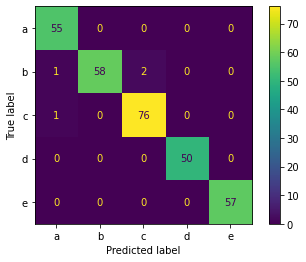

In [45]:
plot_confusion_matrix(model_svm_bow, bow_test, dataset_test["label"])